#使用 Python(Pandas) 做群组分析(Cohort Analysis)

首先为什么要搞这个群组分析呢，由于某种机缘巧合，我进入了O2O餐饮行业，简单点就是个卖饭的，我表示对用户的购买行为还是很感兴趣。

一个群组表示某一类具有特定相同特征的用户群体，这些特征可以是用户注册日期、用户第一次购买行为发生的月份、用户的生日抑或是用户的购买途径等等。群组分析能够通过对这些群体进行实时的追踪，帮助我们发现趋势、了解用户的重复行为（包括购买、访问、花费金额等等），并对用户与收入的留存情况进行监控。这里我们基于用户在平台上进行的第一次“行为”进行分析。

In [1]:
#引入相关包
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import MySQLdb as mysql

%matplotlib inline
pd.set_option('max_columns', 50)
mpl.rcParams['lines.linewidth'] = 2

第一步 读取数据

这里是从订单表里直接读取订单数据

In [2]:
sql = 'SELECT xxx FROM table_name'
conn = mysql.connect(host='mysql_host',port=3306,db='your_db_name',user='username',passwd='password')
data = pd.read_sql(sql, conn)

In [3]:
data.head()

,id,uid,total_price,mobile,create_time,take_time
0,95026,37104,350,18551588538,2016-01-04,2016-01-04
1,95560,6010,1089,13585576428,2016-01-04,2016-01-05
2,95639,119568,250,18616759042,2016-01-05,2016-01-05
3,95863,37104,410,18551588538,2016-01-05,2016-01-05
4,95910,33603,448,13916340391,2016-01-05,2016-01-05


##首选基于 OrderDate 数据构造一个时间段数据列

因为我们想做的是月度的群组分析，所以需要我们着重观察的是月度合计的用户行为。在这种情况下，我们并不需要粒度化的OrderDate数据，只要以月为粒度即可。

In [4]:
import time, datetime

In [5]:
data['OrderPeriod'] = data.take_time.apply(lambda x: datetime.datetime.fromtimestamp(time.mktime(time.strptime(x,"%Y-%m-%d"))).strftime('%Y-%m'))

In [6]:
data.head()

,id,uid,total_price,mobile,create_time,take_time,OrderPeriod
0,95026,37104,350,18551588538,2016-01-04,2016-01-04,2016-01
1,95560,6010,1089,13585576428,2016-01-04,2016-01-05,2016-01
2,95639,119568,250,18616759042,2016-01-05,2016-01-05,2016-01
3,95863,37104,410,18551588538,2016-01-05,2016-01-05,2016-01
4,95910,33603,448,13916340391,2016-01-05,2016-01-05,2016-01


##确定用户的群组（基于用户首次订购）

添加新的一列，并将列名更改为CohortGroup，以表示用户首次购买行为发生的年和月。

In [7]:
data.set_index('uid', inplace=True)
data['CohortGroup'] = data.groupby(level=0)['take_time'].min().apply(lambda x: datetime.datetime.fromtimestamp(time.mktime(time.strptime(x,"%Y-%m-%d"))).strftime('%Y-%m'))
data.reset_index(inplace = True) 

In [8]:
data.head()

,uid,id,total_price,mobile,create_time,take_time,OrderPeriod,CohortGroup
0,37104,95026,350,18551588538,2016-01-04,2016-01-04,2016-01,2016-01
1,6010,95560,1089,13585576428,2016-01-04,2016-01-05,2016-01,2016-01
2,119568,95639,250,18616759042,2016-01-05,2016-01-05,2016-01,2016-01
3,37104,95863,410,18551588538,2016-01-05,2016-01-05,2016-01,2016-01
4,33603,95910,448,13916340391,2016-01-05,2016-01-05,2016-01,2016-01


##按照群组和行为时间汇总数据

为了考察月度群组，我们需要对一个月（OrderPeriod）之中每个CohortGroup的用户数、订购数和花费金额进行加总。

In [9]:
grouped = data.groupby(['CohortGroup', 'OrderPeriod'])

In [10]:
cohorts = grouped.agg({'uid': pd.Series.nunique,
                       'id': pd.Series.nunique,
                       'total_price': np.sum})

In [11]:
cohorts.rename(columns={'uid': 'TotalUsers',
                        'id': 'TotalOrders'}, inplace=True)

In [12]:
cohorts

total_price  TotalUsers  TotalOrders
CohortGroup OrderPeriod                                      
2016-01     2016-01          31634.0          51           68
            2016-02           3940.0           5           12
            2016-03           4475.4           4           12
            2016-04           7344.0           8           14
2016-02     2016-02          23131.9          30           43
            2016-03           6092.0           8           11
            2016-04           8122.0           5           13
2016-03     2016-03          44975.5          72           96
            2016-04          10944.3          10           25
2016-04     2016-04          62765.6          71          151

##标注群组与群组时段

接下来，我们想看看每个群组在发生首次购买之后的几个月中的表现，这要求我们对每个群发生购买之后的每个月进行标记。例如，CohortPeriod = 1表示第一个月，CohortPeriod = 2表示第二个月，以此类推。
这么一来，我们就拥有了在不同的用户活跃阶段对群组进行对比的能力。

In [13]:
def cohort_period(df):
    """
    创建一个名为 `CohortPeriod` 的数据列，代表购买时间与第一次购买时间之间相差的期数
    
    举个例子
    ---------
    比如你想获得到与第一次购买相差3个月的每个用户信息：
        df.sort(['UserId', 'OrderTime', inplace=True)
        df = df.groupby('UserId').apply(cohort_period)
        df[df.CohortPeriod == 3]
    """
    df['CohortPeriod'] = np.arange(len(df)) + 1
    return df

In [14]:
cohorts = cohorts.groupby(level=0).apply(cohort_period)

In [15]:
cohorts

total_price  TotalUsers  TotalOrders  CohortPeriod
CohortGroup OrderPeriod                                                    
2016-01     2016-01          31634.0          51           68             1
            2016-02           3940.0           5           12             2
            2016-03           4475.4           4           12             3
            2016-04           7344.0           8           14             4
2016-02     2016-02          23131.9          30           43             1
            2016-03           6092.0           8           11             2
            2016-04           8122.0           5           13             3
2016-03     2016-03          44975.5          72           96             1
            2016-04          10944.3          10           25             2
2016-04     2016-04          62765.6          71          151             1

##用户群组与用户留存

接下来，我们想要看看随着时间的推移，每个群组中用户数量的变化。需要注意的是，我们关注的是百分比的变化，而非数值的绝对变化。
为了达成目标，我们首先需要构建一个包含了每个断代群以及其规模的pandas时间序列。

In [16]:
cohorts.reset_index(inplace=True)
cohorts.set_index(['CohortGroup', 'CohortPeriod'], inplace=True)
cohort_group_size = cohorts['TotalUsers'].groupby(level=0).first()
cohort_group_size.head()

CohortGroup
2016-01        51
2016-02        30
2016-03        72
2016-04        71
Name: TotalUsers, dtype: int64

整个过程进行完成之后，我们得到的矩阵如下所示：

In [17]:
cohorts['TotalUsers'].unstack(0).head()

/Library/Python/2.7/site-packages/pandas/core/index.py:3141: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return np.sum(name == np.asarray(self.names)) > 1


CohortGroup,2016-01,2016-02,2016-03,2016-04
CohortPeriod,,,,
1,51,30,72,71
2,5,8,10,NaN
3,4,5,NaN,NaN
4,8,NaN,NaN,NaN


然后我们可以将矩阵中的每个元素都除以对应的cohort_group_size。
这样一来，我们便能得到所谓的客户留存率矩阵（user_retention），它显示了各个群组中在对应时间段上发生了购买行为的用户占比，例如在2016年1月份发生购买行为的用户中有9.8%在之后2月份（CohortPeriod＝2）又进行了购买。

In [18]:
user_retention = cohorts['TotalUsers'].unstack(0).divide(cohort_group_size, axis=1)
user_retention.head()

CohortGroup,2016-01,2016-02,2016-03,2016-04
CohortPeriod,,,,
1,1.000000,1.000000,1.000000,1
2,0.098039,0.266667,0.138889,NaN
3,0.078431,0.166667,NaN,NaN
4,0.156863,NaN,NaN,NaN


最后，我们可以运用绘图的方式对群组的时间变化趋势进行展示，以尝试去发现群组之间的行为差异与相似点。常见的两种图表形式为折线图和热图，下文中我们将分别对两种图表进行实现。
可以发现，在图表中每个群组在第一个时段的用户留存率都是100%——这是因为我们的同期群本身就是由用户的首次购买行为确定的。

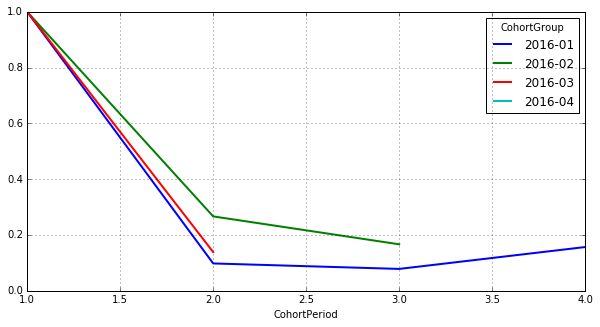

In [19]:
user_retention[['2016-01','2016-02','2016-03','2016-04']].plot(figsize=(10,5))

In [20]:
user_retention.T

CohortPeriod,1,2,3,4
CohortGroup,,,,
2016-01,1,0.098039,0.078431,0.156863
2016-02,1,0.266667,0.166667,NaN
2016-03,1,0.138889,NaN,NaN
2016-04,1,NaN,NaN,NaN


In [21]:
import seaborn as sns

:0: FutureWarning: IPython widgets are experimental and may change in the future.


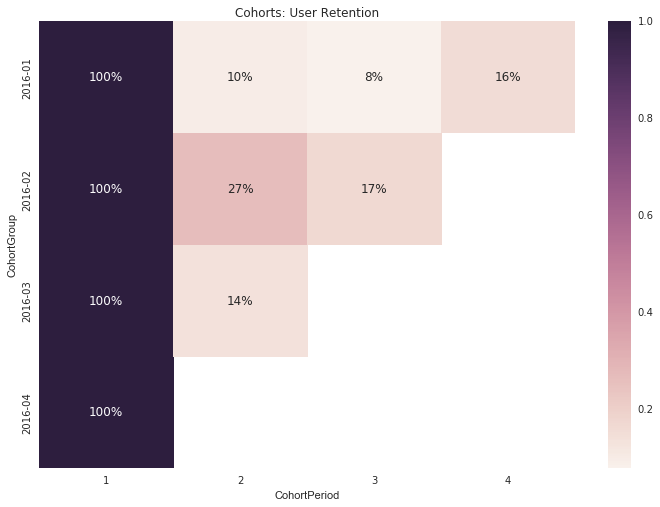

In [22]:
sns.set(style='white')
plt.figure(figsize=(12, 8))
plt.title('Cohorts: User Retention')
sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, fmt='.0%');

和我们的直觉感受相似，我们可以从上面的图表中看到随着时间的流逝，购买的人越来越少。